[neilpy](https://github.com/thomaspingel/neilpy) is the Near Earth Imaging Lab's internal Python development package

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import neilpy
import rasterio
import pdal

In [2]:
# Read data using neilpy's native Python las reader.  Neilpy's reader only supports LAS files, not LAZ.
# To read LAZ files, see the PDAL example

fn = 'data/USGS_LPC_VA_FEMA-NRCS_SouthCentral_2017_D17_17SNB23501450.las'
header, df = neilpy.read_las(fn)

In [3]:
# Create a DSM for comparison and create a bonemap

cellsize = 1  # Units of the input data, in this case meters

Zmax, Tmax = neilpy.create_dem(df.x,df.y,df.z,cellsize=cellsize,bin_type='max',inpaint=True)
Bmax = neilpy.pssm(Zmax,cellsize=cellsize)

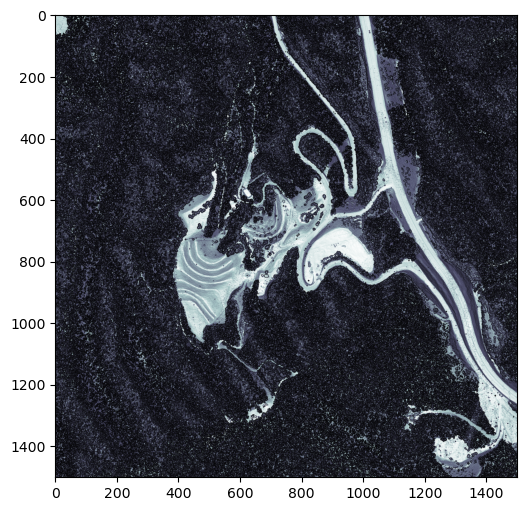

In [13]:
# Inspect the results

plt.figure(figsize=(6,6))
plt.imshow(Bmax,aspect='equal')

In [5]:
# Save the bonemap PNG with a simple worldfile to reference

plt.imsave('out/dsm_bonemap.png',Bmax)
neilpy.write_worldfile(Tmax,'out/dsm_bonemap.pgw')

In [7]:
# Or save the DSM (or other) with a better writer

metadata = {}
metadata['transform'] = Tmax
metadata['crs'] = 'epsg:6346'
neilpy.imwrite('out/dsm.tif',Zmax,metadata=metadata)

In [8]:
# Run SMRF

# Of these parameters, windows is the most important.  This is a progressive opening, in pixels.

windows = 5
slope_threshold = .15
elevation_threshold = .5
elevation_scaler = 1.25

Zsmrf, Tsmrf, obj_cells, obj_points, extras = neilpy.smrf(df.x,df.y,df.z,cellsize,windows,slope_threshold,
                                                  elevation_threshold,elevation_scaler)

In [9]:
# Save filtered DEM
metadata = {}
metadata['transform'] = Tsmrf
metadata['crs'] = 'epsg:6346'
neilpy.imwrite('out/dtm.tif',Zsmrf,metadata=metadata)
    
# Calculate and Save Bonemap
Bsmrf = neilpy.pssm(Zsmrf,cellsize=cellsize)
plt.imsave('out/smrfed_bonemap.png',Bsmrf)
neilpy.write_worldfile(Tsmrf,'out/smrfed_bonemap.pgw')

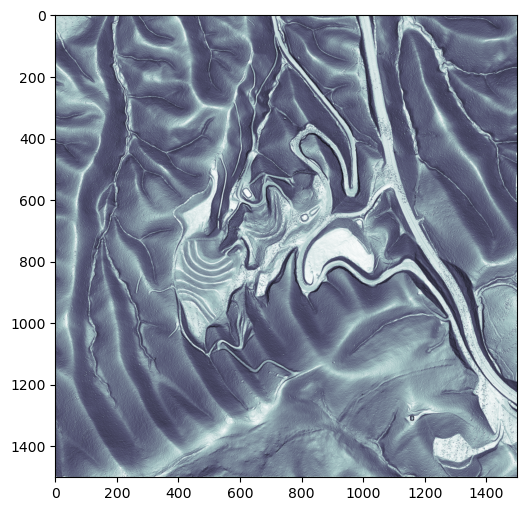

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(Bsmrf,aspect='equal')

In [20]:
# Neilpy doesn't have a laswriter, so we'll have to use PDAL
# Here, all values are overwritten to either 1 or 2 (smrf'ed ground), but
# this could be managed differently as necessary.

pipeline = pdal.Reader(fn).pipeline()
pipeline.execute()
arr = pipeline.arrays[0]

new_class = np.ones_like(arr['Classification'])
new_class[~obj_points] = 2

arr['Classification'] = new_class

pipeline2 = pdal.Writer.las(
    filename="out/smrfed.laz",
    forward="all",
).pipeline(arr)

pipeline2.execute()

25892612